In [1]:
# For scaling features to a specific range (e.g., 0 to 1)
from sklearn.preprocessing import MinMaxScaler

# Optimizer for training neural networks (adaptive learning rate)
from tensorflow.keras.optimizers import Adam

# Basic plotting library for data visualization
import matplotlib.pyplot as plt

# Statistical data visualization library (built on top of matplotlib)
import seaborn as sns

# For working with structured data (like DataFrames)
import pandas as pd

# For numerical operations and working with arrays
import numpy as np

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  # Error metrics
from tensorflow.keras.layers import Input, GRU, LSTM, Dense, Dropout, Add  # Keras layers
from tensorflow.keras.callbacks import EarlyStopping  # Stop training early if no improvement
from tensorflow.keras.models import Sequential  # Simple model architecture
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for time series
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.models import Model  # Functional API model
import tensorflow as tf  # TensorFlow backend
import itertools  # Combinations, permutations, etc.

import warnings
warnings.filterwarnings("ignore")  # Ignore warnings


In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose  # Decompose time series into trend, seasonality, residuals
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller test for stationarity
from pmdarima import auto_arima  # Automatically find best ARIMA model


In [4]:
jj = pd.read_csv('jj.csv')

In [5]:
jj.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


# JJ

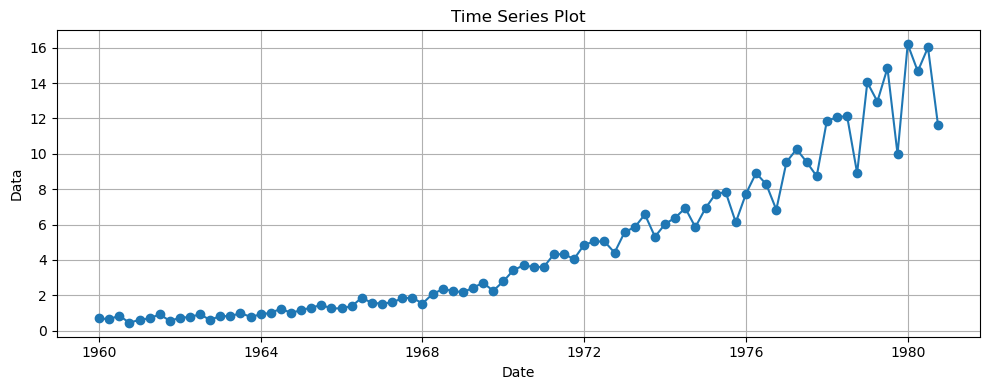

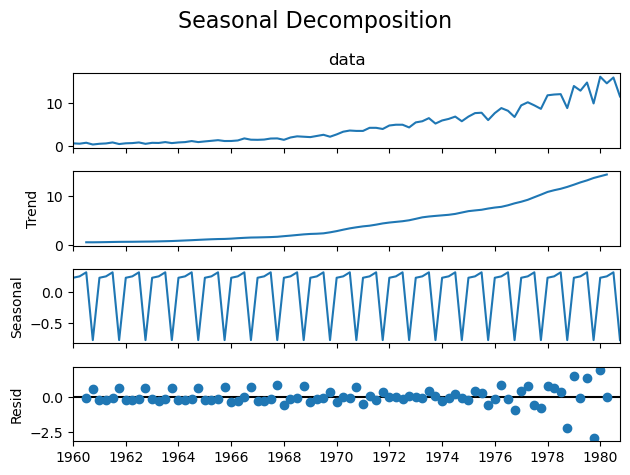

In [6]:
jj['date'] = pd.to_datetime(jj['date'])  # Convert 'date' column to datetime
jj.set_index('date', inplace=True)  # Set 'date' as index

plt.figure(figsize=(10, 4))  # Set plot size
plt.plot(jj, marker='o')  # Plot time series with markers
plt.title("Time Series Plot")  # Title
plt.xlabel("Date")  # X-axis label
plt.ylabel("Data")  # Y-axis label
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot

decomposition = seasonal_decompose(jj['data'], model='additive', period=4)  # Decompose time series

decomposition.plot()  # Plot decomposition (trend, seasonality, residual)
plt.suptitle("Seasonal Decomposition", fontsize=16)  # Main title
plt.tight_layout()  # Adjust layout
plt.show()  # Display plot


In [7]:
adf_result = adfuller(jj['data'])  # Perform ADF test for stationarity
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: 2.7420165734574677
p-value: 1.0


In [8]:
jj_diff = jj.diff().dropna()    # First-order differencing to remove trend and make data stationary

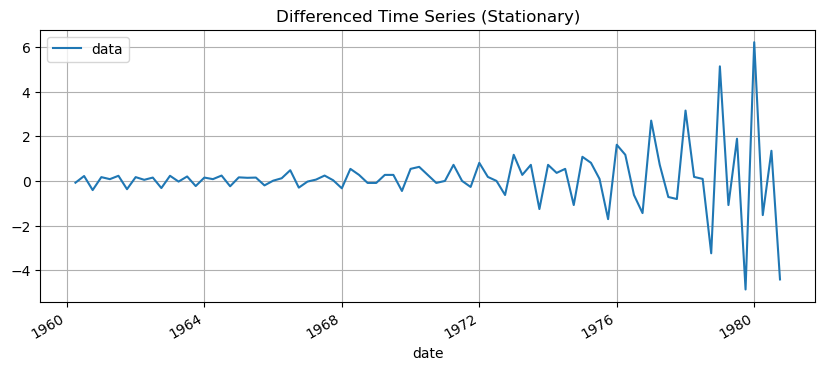

In [9]:
jj_diff.plot(figsize=(10, 4), title="Differenced Time Series (Stationary)")
plt.grid(True)
plt.show()

Best ARIMA order: (4, 1, 1)
Train MSE: 0.1701
Test MSE: 1.0282


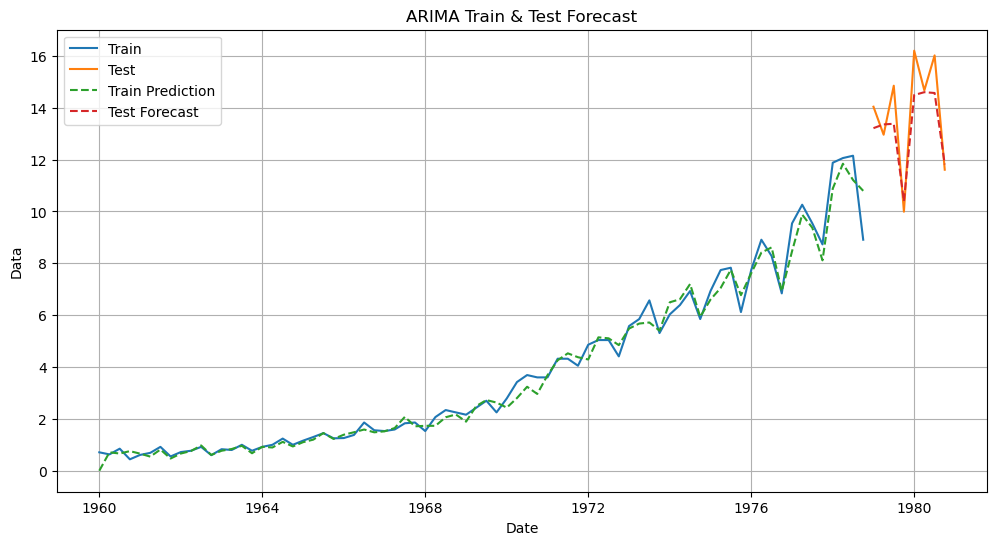

In [10]:
jj = pd.read_csv('jj.csv')

jj['date'] = pd.to_datetime(jj['date'])   # Convert 'date' column to datetime
jj.set_index('date', inplace=True)

train = jj.iloc[:-8]  # Use all data except the last 8 for training
test = jj.iloc[-8:]   # Use the last 8 for testing

# Fit ARIMA model using auto_arima, with seasonal components and AIC for model selection
model = auto_arima(train['data'],
                   seasonal=True,
                   stepwise=True,
                   suppress_warnings=True,
                   error_action='ignore',
                   max_p=5, max_q=5,
                   max_d=5,
                   information_criterion='aic')

print("Best ARIMA order:", model.order)

train_pred = model.predict_in_sample()

test_pred = model.predict(n_periods=len(test))

train_mse = mean_squared_error(train['data'], train_pred)
test_mse = mean_squared_error(test['data'], test_pred)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

# Plot actual vs predicted values for both train and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['data'], label='Train')
plt.plot(test.index, test['data'], label='Test')
plt.plot(train.index, train_pred, label='Train Prediction', linestyle='--')
plt.plot(test.index, test_pred, label='Test Forecast', linestyle='--')
plt.title('ARIMA Train & Test Forecast')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.grid(True)
plt.show()


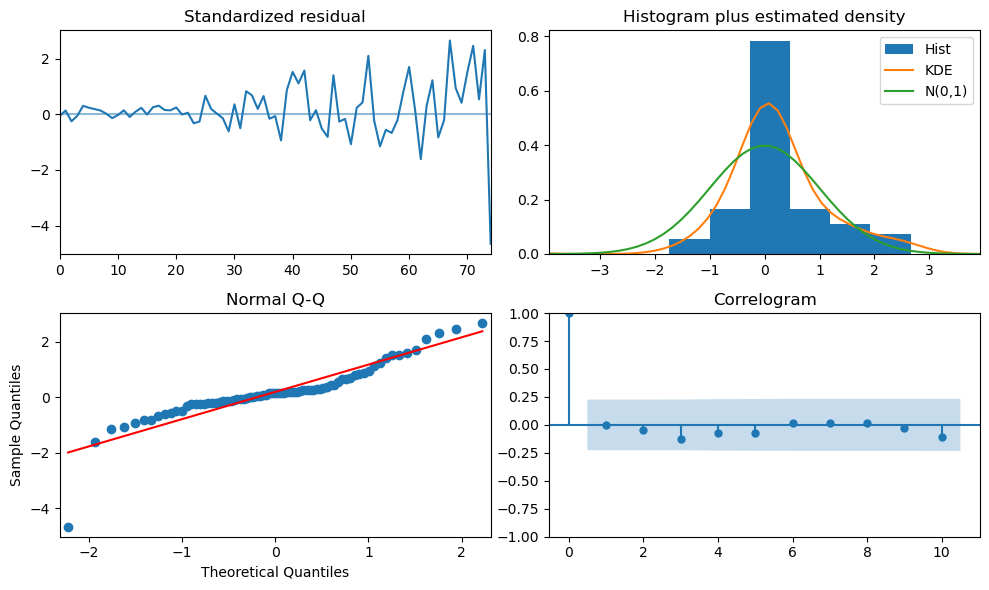

In [11]:
# Plot diagnostic charts to check model residuals and assumptions
model.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()

In [12]:
n_periods = 24  # Set the number of periods to forecast
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)   # Forecast next 24 periods with confidence intervals

In [13]:
last_date = jj.index[-1]

# Generate forecast date range starting 3 months after last date
# Set forecast period to 24 months (start of each month)
forecast_index = pd.date_range(start=last_date + pd.offsets.DateOffset(months=3),
                               periods=n_periods, freq='MS')


In [14]:
forecast_df = pd.DataFrame({'forecast': forecast})
forecast_df.index = forecast_index

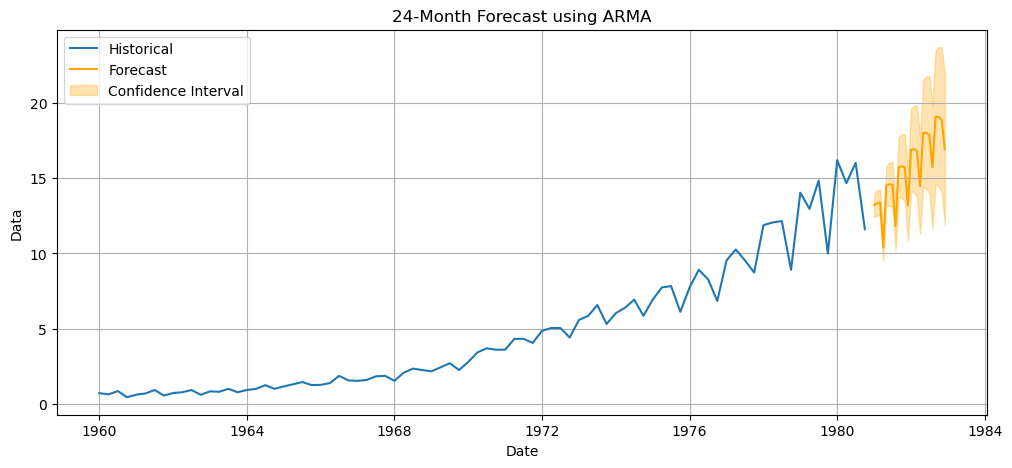

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(jj, label='Historical')
plt.plot(forecast_df, label='Forecast', color='orange')
plt.fill_between(forecast_index,
                 conf_int[:, 0], conf_int[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.title("24-Month Forecast using ARMA")
plt.xlabel("Date")
plt.ylabel("Data")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
jj = pd.read_csv('jj.csv')
jj['date'] = pd.to_datetime(jj['date'])
jj.set_index('date', inplace=True)

train = jj.iloc[:-8]  
test = jj.iloc[-8:]   

In [17]:
train

,data
date,
1960-01-01,0.710000
1960-04-01,0.630000
1960-07-02,0.850000
1960-10-01,0.440000
1961-01-01,0.610000
...,...
1977-10-01,8.729999
1978-01-01,11.880000
1978-04-02,12.060000


In [19]:
def forecast_future(model, last_sequence, n_steps, scaler):
    predictions = []  # Initialize an empty list to store predictions
    current_input = last_sequence.copy()  # Copy the last sequence to start the forecast
    
    for _ in range(n_steps):  # Loop over the number of steps to forecast
        pred = model.predict(current_input[np.newaxis, :, :], verbose=0)[0]  # Predict the next value using the model
        predictions.append(pred[0])  # Append the predicted value to the list
        current_input = np.roll(current_input, -1)  # Roll the sequence (shift values by one position)
        current_input[-1] = pred  # Replace the last value with the predicted value
    
    # Inverse transform the predictions to original scale and return the flattened array
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()


In [20]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(jj[['data']])

train = jj.iloc[:-8]  
test = jj.iloc[-8:]   

# Function to create sequences of data for time series forecasting
def create_sequences(data, window_size):
    X, y = [], []   # Initialize lists for features (X) and target values (y)
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 4
X, y = create_sequences(scaled_data, window_size)
X_train, y_train = X[:-8], y[:-8]  
X_test, y_test = X[-8:], y[-8:]    

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

deep_lstm_model = Sequential([
    LSTM(16, return_sequences=True, input_shape=(window_size, 1)),  # First LSTM layer with 16 units, return sequences for the next LSTM layer
    Dropout(0.3),  #30% of nodes dropped during training
    
    LSTM(32),    # Second LSTM layer with 32 units (no return_sequences since it's the last LSTM layer)
    Dropout(0.3),   # Another dropout laye
    
    Dense(16, activation='relu'),   # Dense layer with 16 units and ReLU activation for non-linearity
    Dense(1)   # Output layer with 1 unit for the prediction
])

# Compile the model with Adam optimizer (learning rate 0.001) and mean squared error loss function
deep_lstm_model.compile(optimizer=Adam(0.001), loss='mse')
deep_lstm_model.fit(X_train, y_train, epochs=200, verbose=0)


In [22]:
last_seq = scaled_data[-window_size:]   # Get the last 'window_size' elements as the initial sequence for forecasting

deep_lstm_forecast = forecast_future(deep_lstm_model, last_seq, 24, scaler)

deep_lstm_pred = deep_lstm_forecast[:8]  # Extract the first 8 predicted values
mse = mean_squared_error(test, deep_lstm_pred)
mae = mean_absolute_error(test, deep_lstm_pred)

print("Deep Stacked LSTM Forecast:")
print("MSE:", mse)
print("MAE:", mae)


Deep Stacked LSTM Forecast:
MSE: 16.55668293141691
MAE: 3.5974512290954594


In [23]:
last_date = jj.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.DateOffset(months=3),
                               periods=n_periods, freq='MS')

forecast_df = pd.DataFrame({'forecast': deep_lstm_forecast})
forecast_df.index = forecast_index

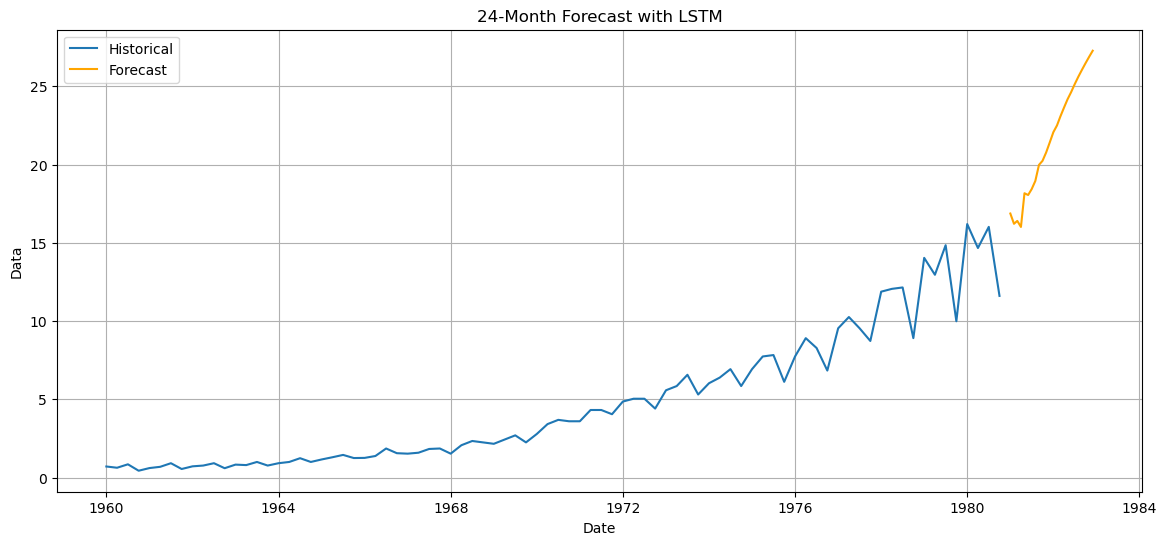

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(jj, label='Historical')
plt.plot(forecast_df.index,forecast_df, label='Forecast', color='orange')
plt.title('24-Month Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('Data')
plt.legend()
plt.grid(True)
plt.show()

# Amazon

In [25]:
import pmdarima as pm

In [26]:
amazon = pd.read_csv('AMZN.csv')

In [27]:
amazon.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
1,2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2,2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
3,2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
4,2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [28]:
amazon['Date'] = pd.to_datetime(amazon['Date'])
amazon.set_index('Date', inplace=True)
ts = amazon['Adj Close']

In [29]:
ts = ts.resample('W').mean()

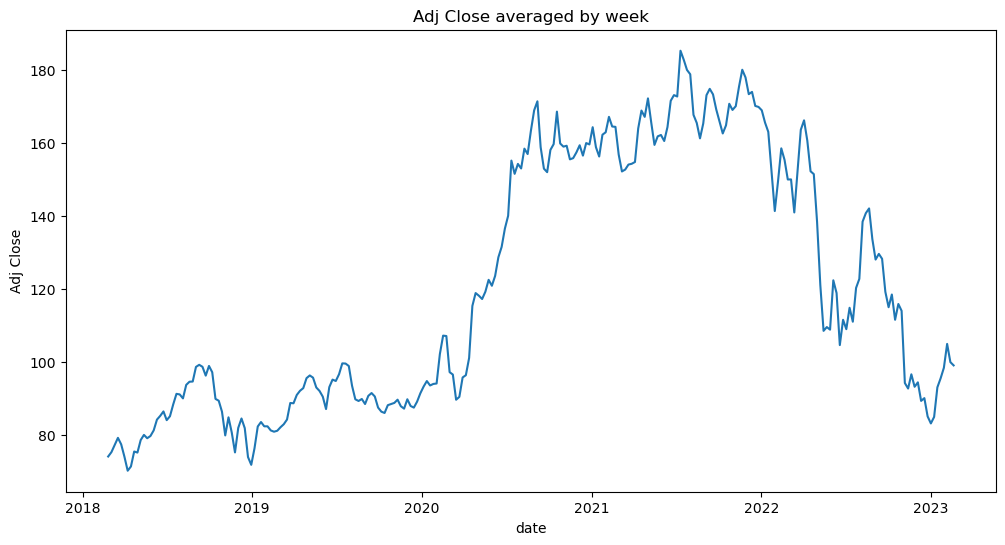

In [30]:
plt.figure(figsize=(12,6))
plt.plot(ts)
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.title('Adj Close averaged by week')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1417.293, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1422.801, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1415.738, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1415.780, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1421.316, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1417.421, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1417.586, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1416.858, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1414.070, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1415.785, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1415.932, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1414.149, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1415.438, Time=0.20 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.729 seconds


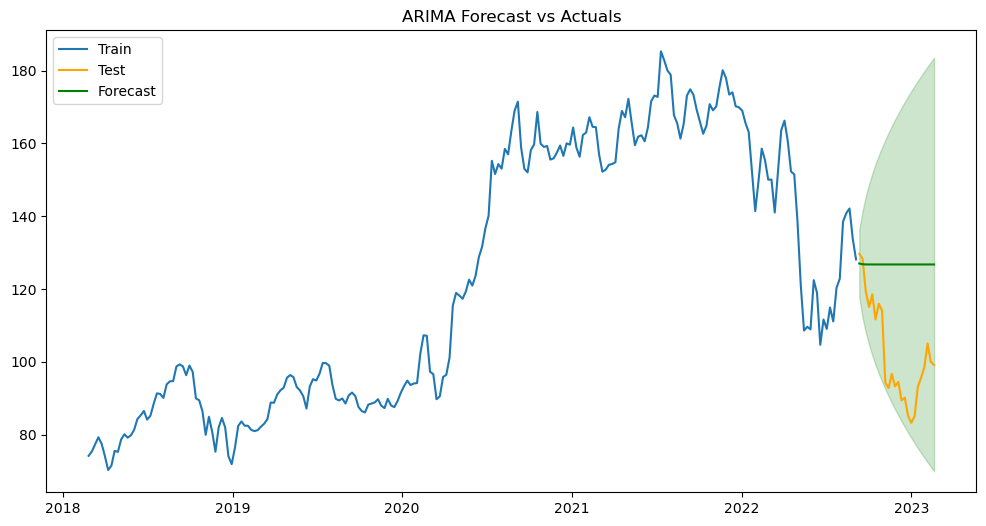

Mean Squared Error Train: 46.1691
Mean Squared Error Test: 790.6885


In [31]:
test_size = 24  # Set the test size to 24 periods

train = ts[:-test_size]  # Use all data except the last 24 rows for training
test = ts[-test_size:]   # Use the last 24 rows for testing

# Fit the ARIMA model using auto_arima with seasonal=False (no seasonality), stepwise search for parameters
model = pm.auto_arima(train, seasonal=False, stepwise=True, 
                      suppress_warnings=True, error_action="ignore", trace=True)

in_sample_pred = model.predict_in_sample()  # Get in-sample predictions for the training data
train_mse = mean_squared_error(train, in_sample_pred)  # Calculate MSE for training data

forecast, conf_int = model.predict(n_periods=test_size, return_conf_int=True)  # Forecast next 24 periods with confidence intervals

forecast_index = test.index  # Use the test data's index for forecast dates

# Create a DataFrame with forecast values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],  # Lower confidence interval
    'Upper CI': conf_int[:, 1]   # Upper confidence interval
}, index=forecast_index)

# Plot the training, test, and forecasted values along with the confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')  
plt.plot(test, label='Test', color='orange')  
plt.plot(forecast_index, forecast, label='Forecast', color='green')  
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)  # Fill confidence interval area
plt.legend()  
plt.title('ARIMA Forecast vs Actuals') 
plt.show()  
mse = mean_squared_error(test, forecast)  # Calculate MSE for the test data
print(f"Mean Squared Error Train: {train_mse:.4f}") 
print(f"Mean Squared Error Test: {mse:.4f}") 


In [32]:
forecast_series = pd.Series(forecast)
forecast_series.index = forecast_index

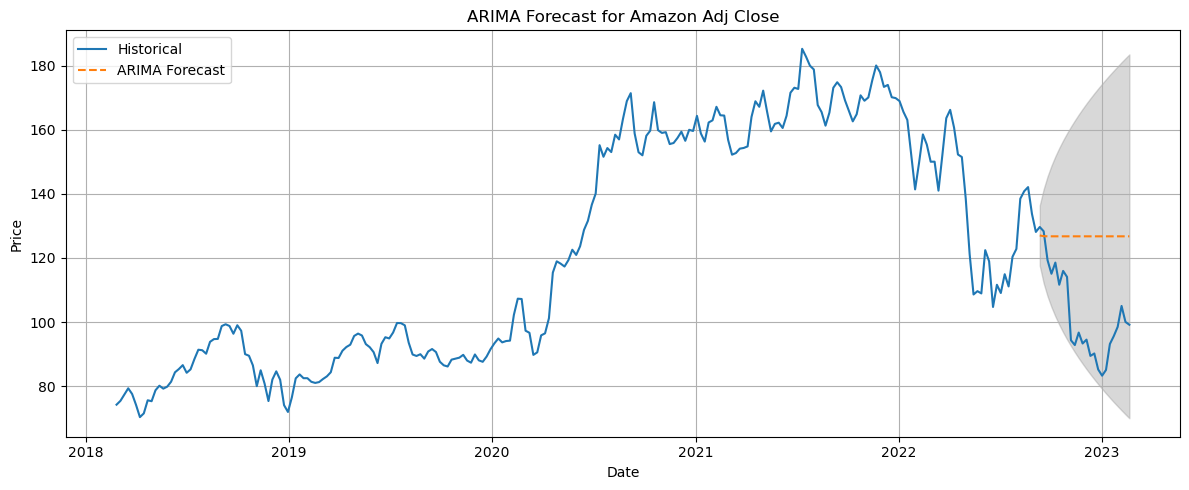

In [33]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical')
plt.plot(forecast_series, label='ARIMA Forecast', linestyle='--')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.3)
plt.title("ARIMA Forecast for Amazon Adj Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
# Set the time series frequency to business days and fill missing values with forward fill
ts = amazon['Adj Close'].asfreq('B').fillna(method='ffill') 

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))  # Scale the 'Adj Close' data and reshape for scaling

In [35]:
train_size = int(len(scaled_ts) * 0.9)
train_data = scaled_ts[:train_size]
test_data = scaled_ts[train_size:]


In [36]:
def create_sequences(data, window_size):
    X, y = [], []  
    for i in range(len(data) - window_size):  # Loop through the data to create sequences
        X.append(data[i:i + window_size])  # Append a window of data as a feature (X)
        y.append(data[i + window_size])  # Append the next value after the window as the target (y)
    return np.array(X), np.array(y) 

window_size = 30  # Set the window size for sequences
X_train, y_train = create_sequences(train_data, window_size)  
X_test, y_test = create_sequences(test_data, window_size)  


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)


In [38]:
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
true_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


In [39]:
ts = amazon['Adj Close'].asfreq('B').fillna(method='ffill') 

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts.values.reshape(-1, 1))

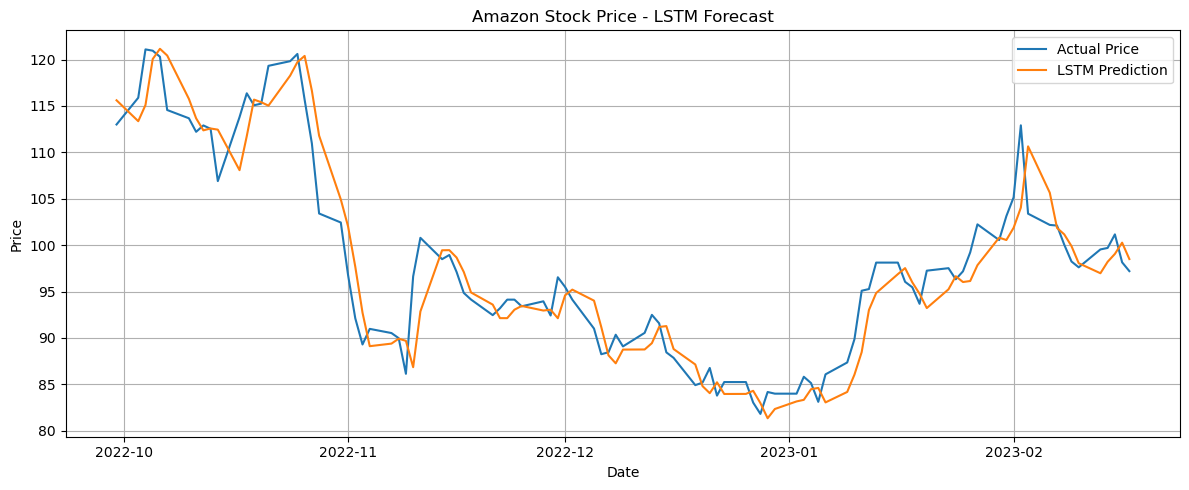

In [40]:
import matplotlib.pyplot as plt

test_dates = ts.index[train_size + window_size:]

plt.figure(figsize=(12, 5))
plt.plot(test_dates, true_prices, label='Actual Price')
plt.plot(test_dates, predicted_prices, label='LSTM Prediction')
plt.title('Amazon Stock Price - LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(true_prices, predicted_prices)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 10.299140167378658


In [42]:
last_sequence = X_test[-1] 
n_steps = 24

future_predictions = []
current_input = last_sequence.copy()

for _ in range(n_steps):
    pred = model.predict(current_input[np.newaxis, :, :], verbose=0)[0]  # Predict the next value using the model
    future_predictions.append(pred[0])
    current_input = np.roll(current_input, -1)  # Shift the sequence by one step (remove first element, move others)
    current_input[-1] = pred  

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Get the last date from the original time series data
last_date = ts.index[-1]

# Create a range of future dates starting the next day after the last date, for 24 business days
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=24, freq='B') 

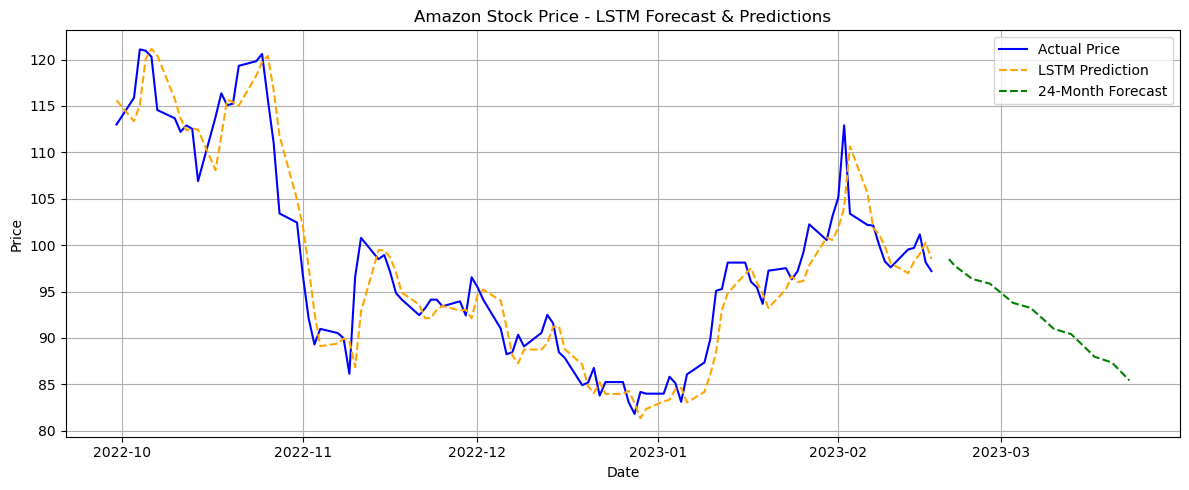

In [43]:
plt.figure(figsize=(12, 5))
plt.plot(ts.index[train_size + window_size:], true_prices, label='Actual Price', color='blue')
plt.plot(ts.index[train_size + window_size:], predicted_prices, label='LSTM Prediction', linestyle='--', color='orange')
plt.plot(future_dates, future_predictions, label='24-Month Forecast', linestyle='--', color='green')
plt.title('Amazon Stock Price - LSTM Forecast & Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
